# Kaggle - Dog Breed Identification

(2017/01/07)

* study LR Finder and Cosine Annealing in fast.ai and implement them for Keras
* cf. https://www.youtube.com/watch?v=IPBSB1HLNLo

# Kaggle Dog Breed Identification

* https://www.kaggle.com/c/dog-breed-identification

In [1]:
import pandas as pd

In [4]:
df_labels_id = pd.read_csv('../Data/Kaggle/dog-breed-identification/labels.csv', index_col='id')
filename_to_breed = df_labels_id.to_dict()['breed']
breeds = sorted(list(df_labels_id['breed'].unique()))
len(breeds)

120

In [5]:
breed_to_id = {}
for i, b in enumerate(breeds): breed_to_id[b] = i
#breed_to_id

filename_to_id = {}
for k, v in filename_to_breed.items():
    filename_to_id[k] = breed_to_id[v]
#filename_to_id

ids = []
for k, v in filename_to_id.items():
    ids.append(v)
len(ids)

10222

In [6]:
import glob

data_files = glob.glob('../Data/Kaggle/dog-breed-identification/train/*.jpg')
data_ys = []
for dt in data_files:
    file_id = dt.split('/')[-1].split('.')[0]
    data_ys.append(filename_to_id[file_id])
    #print(filename_to_breed[file_id])
#data_ys
len(data_files), len(data_ys)

(10222, 10222)

In [7]:
n_train = int(len(data_files) * 0.8)
#n_train
train_files = data_files[:n_train]
train_ys = data_ys[:n_train]
test_files = data_files[n_train:]
test_ys = data_ys[n_train:]
len(train_files), len(test_files)

(8177, 2045)

In [15]:
import joblib
joblib.dump(
    (train_files, train_ys, test_files, test_ys),
    '20180107-kaggle-dog-breed-dataset.dump')

['20180107-kaggle-dog-breed-dataset.dump']

In [16]:
import joblib
train_files, train_ys, test_files, test_ys = joblib.load('20180107-kaggle-dog-breed-dataset.dump')

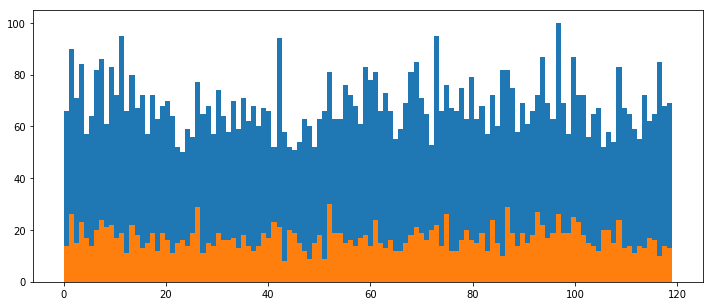

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12, 5))
plt.hist(train_ys, bins=120)
plt.hist(test_ys, bins=120)
plt.show()

In [8]:
def image_ch_swap(x):
    y = np.zeros_like(x)
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            y[i,j] = (x[i,j,2], x[i,j,1], x[i,j,0])
    return y

In [9]:
from PIL import Image
import numpy as np
import random

def generate_batch(batch_size, file_list, label_list, shuffle=True, bgr=False):
    n_batches = len(file_list) // batch_size

    idx = list(range(len(file_list)))
    while 1:
        if shuffle:
            random.shuffle(idx)
        for i in range(n_batches):
            xs = None
            ys = []
            for j in range(batch_size):
                k = i * batch_size + j

                filename = file_list[k]
                img = np.array(Image.open(filename).resize((224, 224)))
                img = img.astype(np.float32)
                img = (img - np.mean(img, axis=(0,1))) / np.std(img, axis=(0,1))
                if bgr: img = image_ch_swap(img)

                if xs is None: xs = np.expand_dims(img, axis=0)
                else: xs = np.concatenate((xs, np.expand_dims(img, axis=0)))

                ys.append(label_list[k])
            yield xs, np.array(ys)

In [10]:
bs = 8
train_gen = generate_batch(bs, train_files, train_ys, shuffle=True)
test_gen = generate_batch(bs, test_files, test_ys, shuffle=False)

In [11]:
#xs, ys = next(train_gen)
xs, ys = next(test_gen)
xs.shape, ys.shape

((8, 224, 224, 3), (8,))

In [12]:
def recover_from_norm(img):
    img_min = img.min(axis=(0, 1))
    img_max = img.max(axis=(0, 1))
    return (img - img_min) / (img_max - img_min)

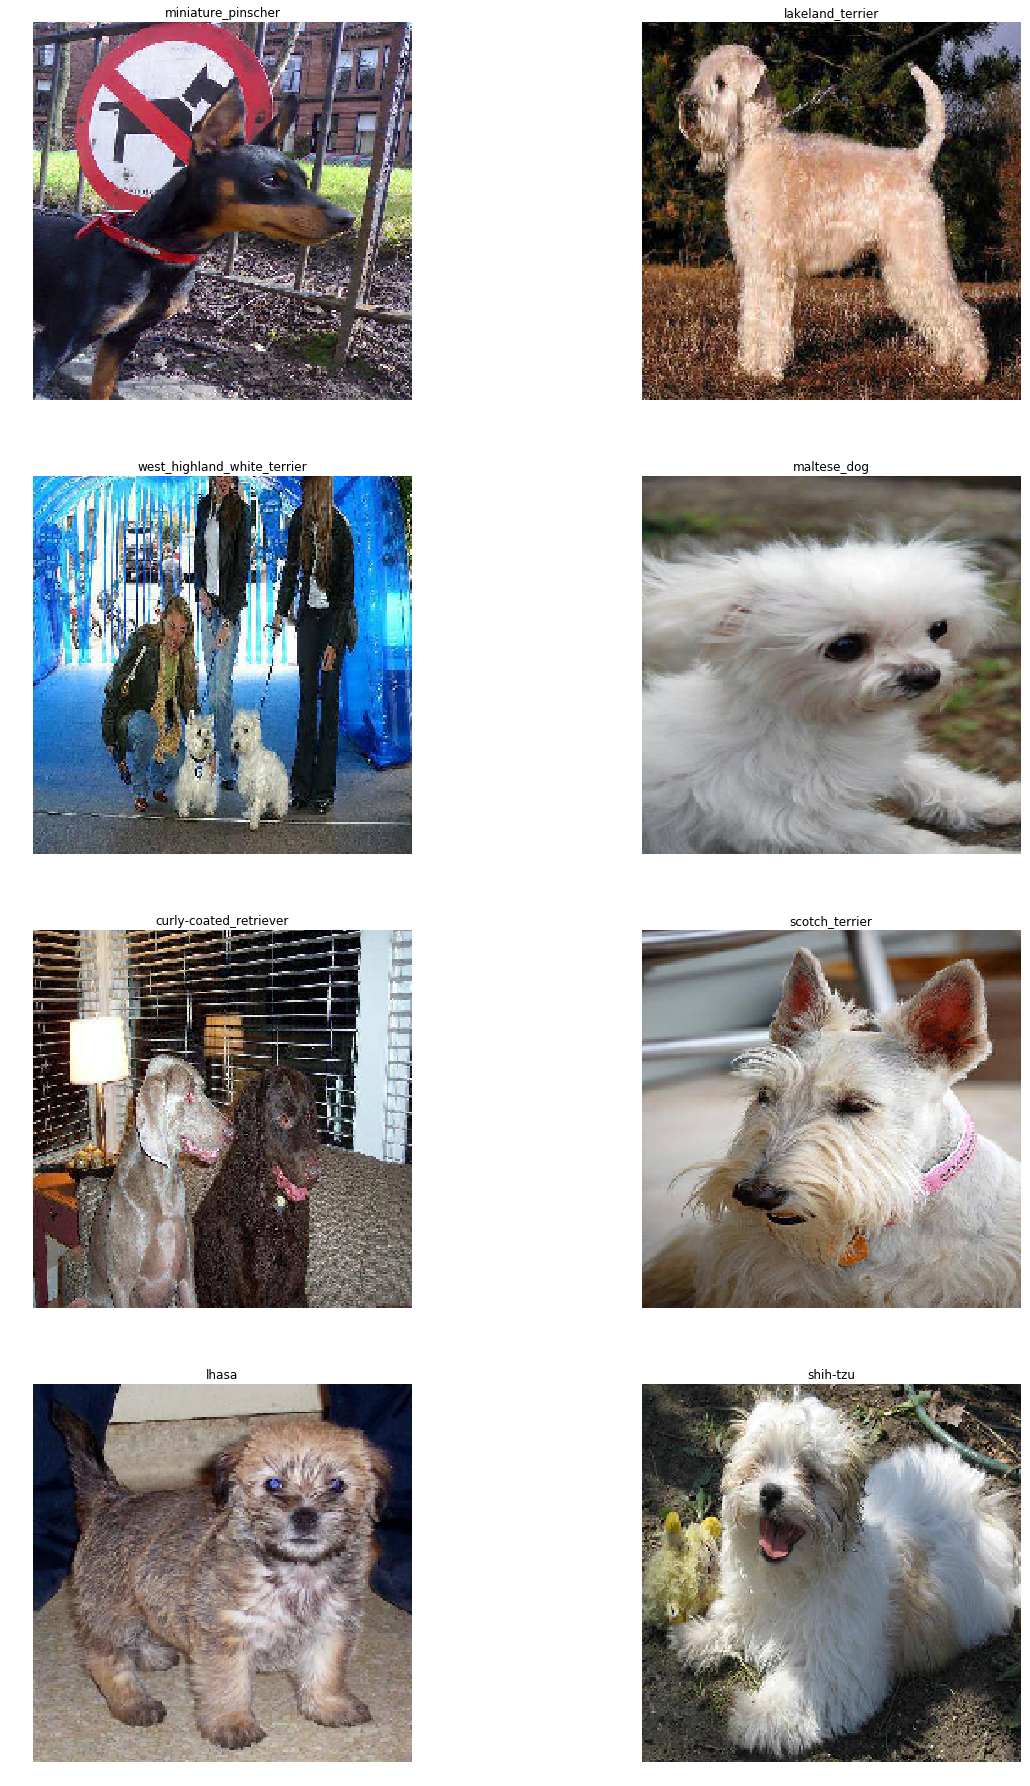

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

n_cols = 2
n_rows = 4

plt.figure(figsize=(10 * n_cols, 8 * n_rows))

for i in range(bs):
    plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(recover_from_norm(xs[i]))
    plt.title(breeds[ys[i]])
    plt.axis('off')

# VGG16

In [21]:
from tensorflow.python import keras

model = keras.applications.vgg16.VGG16()


img_path = data_files[8]
img = keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
x = keras.preprocessing.image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = keras.applications.vgg16.preprocess_input(x)

preds = model.predict(x)
print('Predicted:',
      keras.applications.vgg16.decode_predictions(preds, top=3)[0])

Predicted: [('n02096294', 'Australian_terrier', 0.98626), ('n02093991', 'Irish_terrier', 0.0075475005), ('n02094258', 'Norwich_terrier', 0.0038091978)]


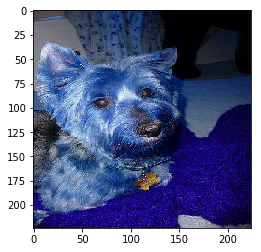

In [22]:
plt.imshow(recover_from_norm(x[0]))
plt.show()

In [23]:
x[0].min(axis=(0,1)), x[0].max(axis=(0,1))

(array([-103.93900299, -116.77899933, -123.68000031], dtype=float32),
 array([ 150.06100464,  136.2210083 ,  131.32000732], dtype=float32))

In [24]:
recover_from_norm(x[0]).min(axis=(0,1)), recover_from_norm(x[0]).max(axis=(0,1))

(array([ 0.,  0.,  0.], dtype=float32), array([ 1.,  1.,  1.], dtype=float32))

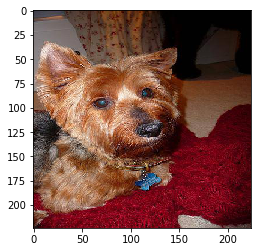

In [25]:
plt.imshow(image_ch_swap(recover_from_norm(x[0])))
plt.show()

# ResNet50

In [26]:
from tensorflow.python import keras

model = keras.applications.resnet50.ResNet50()
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 112, 112, 64)  9472        input_3[0][0]                    
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 112, 112, 64)  256         conv1[0][0]                      
____________________________________________________________________________________________________
activation_50 (Activation)       (None, 112, 112, 64)  0           bn_conv1[0][0]                   
___________________________________________________________________________________________

In [17]:
data_files[0]

'../Data/Kaggle/dog-breed-identification/train/ba26b73f1246de107a9d05840f360c01.jpg'

In [19]:
img_path = data_files[8]
img = keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
x = keras.preprocessing.image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = keras.applications.resnet50.preprocess_input(x)

preds = model.predict(x)
print('Predicted:',
      keras.applications.resnet50.decode_predictions(preds, top=3)[0])

Predicted: [('n02096294', 'Australian_terrier', 0.98097724), ('n02097658', 'silky_terrier', 0.0079735927), ('n02094258', 'Norwich_terrier', 0.0061879898)]


In [41]:
x[0].shape

(224, 224, 3)

In [43]:
x[0].min(axis=(0,1)), x[0].max(axis=(0,1))

(array([-103.93900299, -116.77899933, -123.68000031], dtype=float32),
 array([ 151.06100464,  138.2210083 ,  131.32000732], dtype=float32))

In [51]:
recover_from_norm(x[0]).min(axis=(0,1)),recover_from_norm(x[0]).max(axis=(0,1))

(array([ 0.,  0.,  0.], dtype=float32), array([ 1.,  1.,  1.], dtype=float32))

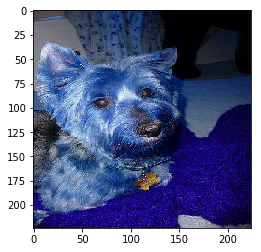

In [20]:
plt.imshow(recover_from_norm(x[0]))
plt.show()

In [53]:
def image_ch_swap(x):
    y = np.zeros_like(x)
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            y[i,j] = (x[i,j,2], x[i,j,1], x[i,j,0])
    return y

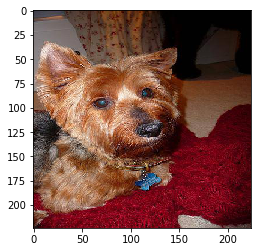

In [54]:
plt.imshow(image_ch_swap(recover_from_norm(x[0])))
plt.show()

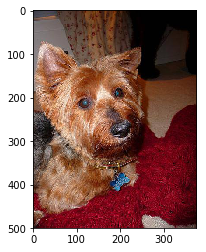

In [52]:
plt.imshow(np.array(Image.open(data_files[8])))
plt.show()

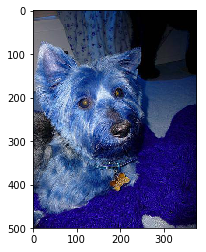

In [55]:
plt.imshow(image_ch_swap(np.array(Image.open(data_files[8]))))
plt.show()

# Fine Tuning for Dog Breed Identification

In [65]:
from tensorflow.python import keras

model = keras.applications.resnet50.ResNet50()

model.layers.pop()
for layer in model.layers:
    layer.trainable = False

num_class = 120

last = model.layers[-1].output
x = keras.layers.Dense(num_class, activation='softmax')(last)
model = keras.models.Model(model.input, x)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_5 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 112, 112, 64)  9472        input_5[0][0]                    
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 112, 112, 64)  256         conv1[0][0]                      
____________________________________________________________________________________________________
activation_148 (Activation)      (None, 112, 112, 64)  0           bn_conv1[0][0]                   
___________________________________________________________________________________________

In [66]:
model.save_weights('20180107-kaggle-dog-breed-resnet50-init_weights.h5')

In [ ]:
model.load_weights('20180107-kaggle-dog-breed-resnet50-init_weights.h5')

In [28]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'])

* VGG16 and ResNet50 somehow require BGR images

In [29]:
steps_per_epoch = len(train_files) // bs
val_steps_per_epoch = len(test_files) // bs

resnet50_01 = model.fit_generator(
    generate_batch(bs, train_files, train_ys, shuffle=True, bgr=True),
    steps_per_epoch=steps_per_epoch,
    validation_data=generate_batch(bs, test_files, test_ys, shuffle=False, bgr=True),
    validation_steps=val_steps_per_epoch,
    epochs=20)

Epoch 1/20
1022/1022 [==============================] - 587s - loss: 2.5370 - sparse_categorical_accuracy: 0.3925 - val_loss: 1.5895 - val_sparse_categorical_accuracy: 0.5843
Epoch 2/20
1022/1022 [==============================] - 514s - loss: 0.9331 - sparse_categorical_accuracy: 0.7354 - val_loss: 1.6444 - val_sparse_categorical_accuracy: 0.6020
Epoch 3/20
1022/1022 [==============================] - 514s - loss: 0.4550 - sparse_categorical_accuracy: 0.8850 - val_loss: 1.6588 - val_sparse_categorical_accuracy: 0.6152
Epoch 4/20
1022/1022 [==============================] - 515s - loss: 0.2129 - sparse_categorical_accuracy: 0.9678 - val_loss: 1.7261 - val_sparse_categorical_accuracy: 0.6142
Epoch 5/20
1022/1022 [==============================] - 514s - loss: 0.1110 - sparse_categorical_accuracy: 0.9928 - val_loss: 1.7653 - val_sparse_categorical_accuracy: 0.6235
Epoch 6/20
 463/1022 [============>.................] - ETA: 221s - loss: 0.0665 - sparse_categorical_accuracy: 0.9984

KeyboardInterrupt: 

# Callbacks

## Learning Rate Finder

In [90]:
from tensorflow.python.keras import backend as K

class LRFinderCallback(keras.callbacks.Callback):
    """Callback to find the optimal learning rate.
    # Arguments
        steps: batch steps for averaging loss for each learning rate
        lr_factor: increasing factor for the next learning rate.
        init_lr: initial learning rate for the search.
    """

    def __init__(self, steps=20, lr_factor=1.2, init_lr=1.0e-6, start_step=0):
        self.steps = steps
        self.lr_factor = lr_factor
        self.lr = init_lr
        self.start_step = start_step

        self.lrs = []
        self.losses = []

        self.counter = 0
        self.accumulated_loss = 0.0
        self.init_loss = None

    def on_batch_begin(self, batch, logs=None):
        """Called right before processing a batch.
        # Arguments
            batch: integer, index of batch within the current epoch.
            logs: dictionary of logs.
        """
        self.counter += 1
        if self.counter <= self.start_step: return
        if self.counter % self.steps == 0:
            self.lr *= self.lr_factor
            K.set_value(self.model.optimizer.lr, self.lr)

    def on_batch_end(self, batch, logs=None):
        """Called at the end of a batch.
        # Arguments
            batch: integer, index of batch within the current epoch.
            logs: dictionary of logs.
        """
        if self.counter <= self.start_step: return
        logs = logs or {}
        loss = logs.get('loss')
        if self.init_loss is None: self.init_loss = loss
        if self.counter % self.steps == 0:
            ave_loss = self.accumulated_loss / float(self.steps)
            lr = float(K.get_value(self.model.optimizer.lr))
            self.lrs.append(lr)
            self.losses.append(ave_loss)
            if ave_loss > self.init_loss * 2.0: self.model.stop_training = True
            self.accumulated_loss = 0.0
        self.accumulated_loss += loss

In [98]:
model.load_weights('20180107-kaggle-dog-breed-resnet50-init_weights.h5')
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'])

lr_finder_1 = LRFinderCallback()

resnet50_test = model.fit_generator(
    generate_batch(bs, train_files, train_ys, shuffle=True, bgr=True),
    steps_per_epoch=steps_per_epoch,
    validation_data=generate_batch(bs, test_files, test_ys, shuffle=False, bgr=True),
    validation_steps=val_steps_per_epoch,
    callbacks=[lr_finder_1],
    verbose=2,
    epochs=20)

# optimizer: <tensorflow.python.keras._impl.keras.optimizers.Adam object at 0x7f36f1123128>
Epoch 1/20
# on_batch_end: lr=1.200000e-06, loss=5.891169e+00
# on_batch_end: lr=1.440000e-06, loss=6.349866e+00
# on_batch_end: lr=1.728000e-06, loss=6.025703e+00
# on_batch_end: lr=2.073600e-06, loss=6.399510e+00
# on_batch_end: lr=2.488320e-06, loss=6.341969e+00
# on_batch_end: lr=2.985984e-06, loss=6.117489e+00
# on_batch_end: lr=3.583181e-06, loss=6.244466e+00
# on_batch_end: lr=4.299817e-06, loss=6.164773e+00
# on_batch_end: lr=5.159780e-06, loss=5.746824e+00
# on_batch_end: lr=6.191736e-06, loss=6.057751e+00
# on_batch_end: lr=7.430084e-06, loss=6.147315e+00
# on_batch_end: lr=8.916100e-06, loss=6.046638e+00
# on_batch_end: lr=1.069932e-05, loss=5.887569e+00
# on_batch_end: lr=1.283918e-05, loss=5.961423e+00
# on_batch_end: lr=1.540702e-05, loss=6.024111e+00
# on_batch_end: lr=1.848843e-05, loss=5.958936e+00
# on_batch_end: lr=2.218611e-05, loss=5.697283e+00
# on_batch_end: lr=2.662333e-0

In [92]:
model.load_weights('20180107-kaggle-dog-breed-resnet50-init_weights.h5')
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'])

lr_finder_2 = LRFinderCallback(steps=10, lr_factor=1.1, init_lr=1.0e-5)

resnet50_test = model.fit_generator(
    generate_batch(bs, train_files, train_ys, shuffle=True, bgr=True),
    steps_per_epoch=steps_per_epoch,
    validation_data=generate_batch(bs, test_files, test_ys, shuffle=False, bgr=True),
    validation_steps=val_steps_per_epoch,
    callbacks=[lr_finder_2],
    verbose=2,
    epochs=20)

# optimizer: <tensorflow.python.keras._impl.keras.optimizers.Adam object at 0x7f36fb6d1a58>
Epoch 1/20
# on_batch_end: lr=1.100000e-05, loss=5.290210e+00
# on_batch_end: lr=1.210000e-05, loss=6.430757e+00
# on_batch_end: lr=1.331000e-05, loss=6.719009e+00
# on_batch_end: lr=1.464100e-05, loss=6.432305e+00
# on_batch_end: lr=1.610510e-05, loss=6.349920e+00
# on_batch_end: lr=1.771561e-05, loss=6.457389e+00
# on_batch_end: lr=1.948717e-05, loss=6.380504e+00
# on_batch_end: lr=2.143589e-05, loss=6.402685e+00
# on_batch_end: lr=2.357948e-05, loss=6.215903e+00
# on_batch_end: lr=2.593742e-05, loss=6.116806e+00
# on_batch_end: lr=2.853117e-05, loss=6.031779e+00
# on_batch_end: lr=3.138428e-05, loss=5.812142e+00
# on_batch_end: lr=3.452271e-05, loss=5.990507e+00
# on_batch_end: lr=3.797498e-05, loss=5.838327e+00
# on_batch_end: lr=4.177248e-05, loss=5.606053e+00
# on_batch_end: lr=4.594973e-05, loss=5.678409e+00
# on_batch_end: lr=5.054470e-05, loss=5.252632e+00
# on_batch_end: lr=5.559917e-0

In [94]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'])
model.load_weights('20180107-kaggle-dog-breed-resnet50-init_weights.h5')

lr_finder_3 = LRFinderCallback(steps=5, lr_factor=1.1, init_lr=1.0e-5)

resnet50_test = model.fit_generator(
    generate_batch(bs, train_files, train_ys, shuffle=True, bgr=True),
    steps_per_epoch=steps_per_epoch,
    validation_data=generate_batch(bs, test_files, test_ys, shuffle=False, bgr=True),
    validation_steps=val_steps_per_epoch,
    callbacks=[lr_finder_3],
    verbose=2,
    epochs=20)

# optimizer: <tensorflow.python.keras._impl.keras.optimizers.Adam object at 0x7f36fbb52860>
Epoch 1/20
# on_batch_end: lr=1.100000e-05, loss=4.229052e+00
# on_batch_end: lr=1.210000e-05, loss=5.941226e+00
# on_batch_end: lr=1.331000e-05, loss=5.659759e+00
# on_batch_end: lr=1.464100e-05, loss=5.728063e+00
# on_batch_end: lr=1.610510e-05, loss=5.841625e+00
# on_batch_end: lr=1.771561e-05, loss=5.859219e+00
# on_batch_end: lr=1.948717e-05, loss=6.018071e+00
# on_batch_end: lr=2.143589e-05, loss=5.738398e+00
# on_batch_end: lr=2.357948e-05, loss=5.331365e+00
# on_batch_end: lr=2.593742e-05, loss=5.894447e+00
# on_batch_end: lr=2.853117e-05, loss=5.652499e+00
# on_batch_end: lr=3.138428e-05, loss=5.901361e+00
# on_batch_end: lr=3.452271e-05, loss=5.624137e+00
# on_batch_end: lr=3.797498e-05, loss=5.592179e+00
# on_batch_end: lr=4.177248e-05, loss=5.601418e+00
# on_batch_end: lr=4.594973e-05, loss=5.525674e+00
# on_batch_end: lr=5.054470e-05, loss=5.158866e+00
# on_batch_end: lr=5.559917e-0

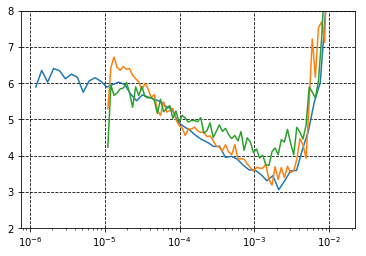

In [99]:
import math

plt.semilogx(lr_finder_1.lrs, lr_finder_1.losses)
plt.semilogx(lr_finder_2.lrs, lr_finder_2.losses)
plt.semilogx(lr_finder_3.lrs, lr_finder_3.losses)
plt.ylim(2.0, 8.0)
plt.grid(which='major',color='k',linestyle='--')
plt.show()

## Cosine Annealing

In [164]:
class CosAnnealingCallback(keras.callbacks.Callback):
    """Callback to train with cosine annealing for learning rate.
    # Arguments
        steps: batch steps for averaging loss for each learning rate.
        lr_start: the initial, the highest, learning rate.
        lr_end: the final, the lowest, learning rate.
        cycle: number of cycles of cosine annealing for the steps.
    """

    def __init__(self, steps=1000, lr_start=1.0e-3, lr_end=1.0e-4, cycle=1):
        self.steps = steps
        
        self.lr_table = []
        lr_a = (lr_start - lr_end) * 0.5
        lr_b = lr_end
        period = self.steps // cycle
        for i in range(steps):
            j = i % period
            t = float(j) / float(period) * math.pi
            lr = lr_a * (math.cos(t) + 1.0) + lr_b
            self.lr_table.append(lr)
        #self.lr_table.append(lr_end)

    def on_train_begin(self, logs=None):
        """Called at the beginning of training.
        # Arguments
            logs: dictionary of logs.
        """
        self.counter = -1
        K.set_value(self.model.optimizer.lr, self.lr_table[0])

    def on_batch_begin(self, batch, logs=None):
        """Called right before processing a batch.
        # Arguments
            batch: integer, index of batch within the current epoch.
            logs: dictionary of logs.
        """
        self.counter += 1
        i = self.counter % self.steps
        K.set_value(self.model.optimizer.lr, self.lr_table[i])
        #print('# on_batch_begin:', batch, i)

    #def on_batch_end(self, batch, logs=None):
    #    """Called at the end of a batch.
    #    # Arguments
    #        batch: integer, index of batch within the current epoch.
    #        logs: dictionary of logs.
    #    """
    #    #cycle = self.counter // self.steps
    #    #if cycle >= self.cycle:
    #    #    self.model.stop_training = True

    def on_epoch_end(self, epoch, logs=None):
        self.counter = -1

    #def on_train_end(self, logs=None):
    #    """Called at the end of training.
    #    # Arguments
    #        logs: dictionary of logs.
    #    """
    #    #print('# on_train_end')

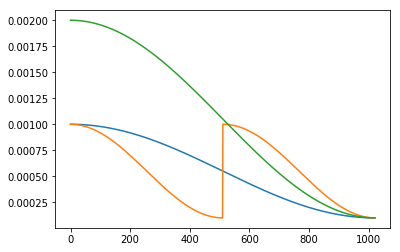

In [178]:
cos_ann1 = CosAnnealingCallback(steps=steps_per_epoch, cycle=1)
cos_ann2 = CosAnnealingCallback(steps=steps_per_epoch, cycle=2)
cos_ann1a = CosAnnealingCallback(steps=steps_per_epoch, cycle=1, lr_start=2.0e-3)
plt.plot(cos_ann1.lr_table)
plt.plot(cos_ann2.lr_table)
plt.plot(cos_ann1a.lr_table)
plt.show()

In [121]:
len(test_ys)

2045

In [128]:
from tqdm import tqdm

val_xs = None
val_ys = None
gen_test = generate_batch(bs, test_files, test_ys, shuffle=False, bgr=True)
for i in tqdm(range(val_steps_per_epoch)):
    xs, ys = next(gen_test)

    if val_xs is None: val_xs = xs
    else: val_xs = np.concatenate((val_xs, xs))

    if val_ys is None: val_ys = ys
    else: val_ys = np.concatenate((val_ys, ys))

val_xs.shape, val_ys.shape

100%|██████████| 255/255 [02:27<00:00,  1.73it/s]


((2040, 224, 224, 3), (2040,))

In [132]:
def np_sparse_categorical_accuracy(y_true, y_pred):
    return np.mean(
        np.equal(
            y_true,
            np.argmax(y_pred, axis=-1).astype(np.float32)).astype(np.float32))

In [176]:
model.load_weights('20180107-kaggle-dog-breed-resnet50-init_weights.h5')
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'])

resnet50_test = model.fit_generator(
    generate_batch(bs, train_files, train_ys, shuffle=True, bgr=True),
    steps_per_epoch=steps_per_epoch,
    validation_data=generate_batch(bs, test_files, test_ys, shuffle=False, bgr=True),
    validation_steps=val_steps_per_epoch,
    verbose=1,
    epochs=2)

Epoch 1/2
1022/1022 [==============================] - 518s - loss: 2.5457 - sparse_categorical_accuracy: 0.3886 - val_loss: 1.5797 - val_sparse_categorical_accuracy: 0.5971
Epoch 2/2
1022/1022 [==============================] - 515s - loss: 0.9340 - sparse_categorical_accuracy: 0.7334 - val_loss: 1.6141 - val_sparse_categorical_accuracy: 0.6147


In [177]:
model.save_weights('20180107-kaggle-dog-breed-resnet50-no_cos_ann_weights.h5')

In [167]:
model.load_weights('20180107-kaggle-dog-breed-resnet50-init_weights.h5')
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'])

resnet50_test = model.fit_generator(
    generate_batch(bs, train_files, train_ys, shuffle=True, bgr=True),
    steps_per_epoch=steps_per_epoch,
    validation_data=generate_batch(bs, test_files, test_ys, shuffle=False, bgr=True),
    validation_steps=val_steps_per_epoch,
    callbacks=[cos_ann1],
    verbose=1,
    epochs=2)

Epoch 1/2
1022/1022 [==============================] - 522s - loss: 2.4099 - sparse_categorical_accuracy: 0.4165 - val_loss: 1.3312 - val_sparse_categorical_accuracy: 0.6314
Epoch 2/2
1022/1022 [==============================] - 515s - loss: 1.1245 - sparse_categorical_accuracy: 0.6948 - val_loss: 1.2243 - val_sparse_categorical_accuracy: 0.6637


In [170]:
model.save_weights('20180107-kaggle-dog-breed-resnet50-cos_ann1_weights.h5')

In [168]:
preds_cos_ann1 = model.predict_generator(
    generate_batch(bs, test_files, test_ys, shuffle=False, bgr=True),
    steps=val_steps_per_epoch,
    verbose=1)

255/255 [==============================] - 103s   


In [171]:
val_acc = np_sparse_categorical_accuracy(val_ys, preds_cos_ann1)
val_acc

0.6637255

In [172]:
model.load_weights('20180107-kaggle-dog-breed-resnet50-init_weights.h5')
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'])

resnet50_test = model.fit_generator(
    generate_batch(bs, train_files, train_ys, shuffle=True, bgr=True),
    steps_per_epoch=steps_per_epoch,
    validation_data=generate_batch(bs, test_files, test_ys, shuffle=False, bgr=True),
    validation_steps=val_steps_per_epoch,
    callbacks=[cos_ann2],
    verbose=1,
    epochs=2)

Epoch 1/2
1022/1022 [==============================] - 518s - loss: 2.5050 - sparse_categorical_accuracy: 0.4007 - val_loss: 1.3267 - val_sparse_categorical_accuracy: 0.6343
Epoch 2/2
1022/1022 [==============================] - 514s - loss: 1.1184 - sparse_categorical_accuracy: 0.6956 - val_loss: 1.2257 - val_sparse_categorical_accuracy: 0.6623


In [173]:
model.save_weights('20180107-kaggle-dog-breed-resnet50-cos_ann2_weights.h5')

In [174]:
preds_cos_ann2 = model.predict_generator(
    generate_batch(bs, test_files, test_ys, shuffle=False, bgr=True),
    steps=val_steps_per_epoch,
    verbose=1)

255/255 [==============================] - 102s   


In [175]:
val_acc = np_sparse_categorical_accuracy(val_ys, preds_cos_ann2)
val_acc

0.66225493

In [179]:
model.load_weights('20180107-kaggle-dog-breed-resnet50-init_weights.h5')
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'])

resnet50_test = model.fit_generator(
    generate_batch(bs, train_files, train_ys, shuffle=True, bgr=True),
    steps_per_epoch=steps_per_epoch,
    validation_data=generate_batch(bs, test_files, test_ys, shuffle=False, bgr=True),
    validation_steps=val_steps_per_epoch,
    callbacks=[cos_ann1a],
    verbose=1,
    epochs=2)

Epoch 1/2
1022/1022 [==============================] - 522s - loss: 2.5211 - sparse_categorical_accuracy: 0.4271 - val_loss: 1.2813 - val_sparse_categorical_accuracy: 0.6466
Epoch 2/2
1022/1022 [==============================] - 516s - loss: 1.1110 - sparse_categorical_accuracy: 0.6943 - val_loss: 1.3462 - val_sparse_categorical_accuracy: 0.6505


In [180]:
model.save_weights('20180107-kaggle-dog-breed-resnet50-cos_ann1a_weights.h5')

In [181]:
preds_cos_ann1a = model.predict_generator(
    generate_batch(bs, test_files, test_ys, shuffle=False, bgr=True),
    steps=val_steps_per_epoch,
    verbose=1)

255/255 [==============================] - 103s   


In [182]:
val_acc = np_sparse_categorical_accuracy(val_ys, preds_cos_ann1a)
val_acc

0.65049022